# Problem 1

In [1]:
import numpy as np

def fft(x):
    n = x.size
    assert n & (n - 1) == 0, "size of vector should be power of 2"
    w = np.exp(-2 * np.pi * 1j / n * np.arange(n >> 1))
    
    def fft(i, n, s):
        if n == 1:
            return x[i]
        n >>= 1
        left = fft(i, n, s << 1)
        right = fft(i + s, n, s << 1)
        right *= w[::s]
        return np.append(left + right, left - right)
    
    return fft(0, n, 1)

The slowest run took 7.37 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 10 µs per loop
1000 loops, best of 3: 443 µs per loop
The slowest run took 5.75 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 10.3 µs per loop
1000 loops, best of 3: 895 µs per loop
The slowest run took 6.59 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 13.6 µs per loop
1000 loops, best of 3: 1.76 ms per loop
The slowest run took 5.17 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 15.5 µs per loop
100 loops, best of 3: 3.54 ms per loop
The slowest run took 4.30 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 19.3 µs per loop
100 loops, best of 3: 7 ms per loop
10000 loo

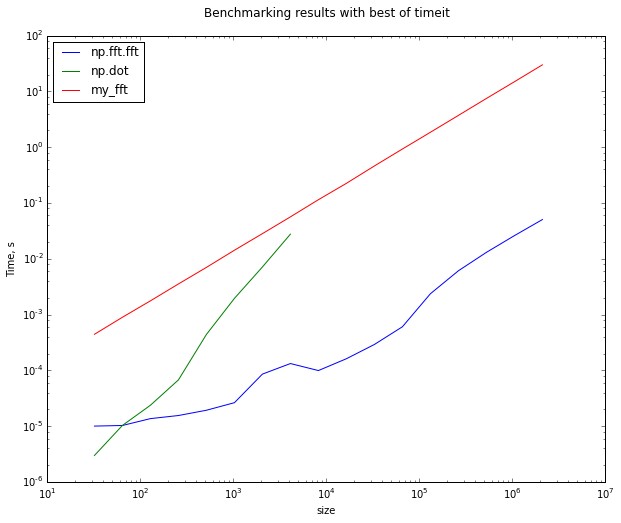

In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

def plot_results(all_values):
    
    plt.figure(figsize=(10,8))
    
    for bench_name, points in all_values.iteritems():
        sizes = points[1]
        values = points[0]
        plt.loglog(sizes, values, label=bench_name)
        slope, intercept=np.polyfit(np.log(sizes[-7:]), np.log(values[-7:]), 1)
        print bench_name, 'slope', slope, 'intercept', intercept, '\n' 
    
    plt.legend(loc='best')
    plt.title('Benchmarking results with best of timeit', y=1.03)
    plt.xlabel('size')
    plt.ylabel('Time, s')
    
def fourier_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N)
    W = np.power(omega, i * j)
    return W
    
points = [1 << (i + 5) for i in range(17)]
my_fft = []
np_fft = []
dot = []

for i in points:
    x = np.random.rand(i)
    res = %timeit -o np.fft.fft(x)
    np_fft.append(res.best)
    res = %timeit -o fft(x)
    my_fft.append(res.best)
    
for i in points[:8]:
    x = np.random.rand(i)
    W = fourier_matrix(i)
    res = %timeit -o W.dot(x)
    dot.append(res.best)
    
plot_results({'my_fft': (my_fft, points), 'np.fft.fft': (np_fft, points), 'np.dot': (dot, points[:8])})

# Problem 2

In [ ]:
def strassen(A, B):
    
    n = A.shape[0]
    def strassen(A, B, n):
        if n == 1:
            return A * B
        n >>= 1
        a11 = A[:n, :n]
        a12 = A[:n, n:]
        a21 = A[n:, :n]
        a22 = A[n:, n:]
        b11 = B[:n, :n]
        b12 = B[:n, n:]
        b21 = B[n:, :n]
        b22 = B[n:, n:]
        f1 = strassen(a11 + a22, b11 + b22, n)
        f2 = strassen(a21 + a22, b11, n)
        f3 = strassen(a11, b12 - b22, n)
        f4 = strassen(a22, b21 - b11, n)
        f5 = strassen(a11 + a12, b22, n)
        f6 = strassen(a21 - a11, b11 + b12, n)
        f7 = strassen(a12 - a22, b21 + b22, n)
        c11 = f1 + f4 - f5 + f7
        c12 = f3 + f5
        c21 = f2 + f4
        c22 = f1 - f2 + f3 + f6
        return np.append(np.append(c11, c12, axis = 1), np.append(c21, c22, axis = 1), axis = 0)
    
    return strassen(A, B, n)

A = np.random.rand(1 << 5, 1 << 5)
B = np.random.rand(1 << 5, 1 << 5)
print np.linalg.norm(A.dot(B) - strassen(A, B))

# Problem 3

In [ ]:
def fast_convolution(alpha, x):
    n = x.size
    v = np.copy(x)
    v = np.append(v, np.zeros(n - 1))
    t = np.sqrt(alpha / np.pi) * np.exp(-alpha * np.append(np.arange(n), np.arange(n - 1) - n + 1) ** 2)
    return np.real(np.fft.ifft(np.fft.fft(t) * np.fft.fft(v))[:n])

In [ ]:
from scipy.io import wavfile
from scipy.signal import resample
from IPython.core.display import HTML
from IPython.core.display import display
import sys
import StringIO
import base64
import struct

def load_wav(filename):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    return rate, data.astype(np.int16)
  
def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))
    
rate, sound = load_wav('sample.wav')
smooth_sound = fast_convolution(1./20, sound)
wavPlayer(smooth_sound.astype(np.int16), rate)

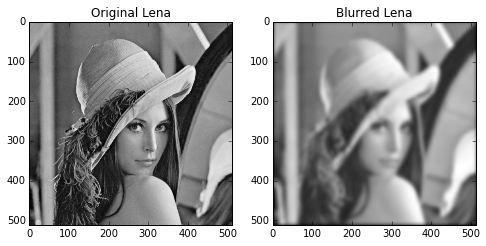

In [12]:
def fast_convolution2d(alpha, x):
    (n, m) = x.shape
    x_ind = np.append(np.arange(n), np.arange(n - 1) - n + 1)
    y_ind = np.append(np.arange(m), np.arange(m - 1) - m + 1)
    i, j = np.meshgrid(x_ind, y_ind)
    v = np.copy(x)
    v = np.pad(v, ((0, n - 1), (0, m - 1)), 'constant')
    T = alpha / np.pi * np.exp(-alpha * (i ** 2 + j ** 2))
    return np.real(np.fft.ifft2(np.fft.fft2(T) * np.fft.fft2(v))[:n, :m])

from scipy import misc
lena = misc.lena()
smooth_lena = fast_convolution2d(1./50, lena)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(lena, cmap = 'gray')
ax[0].set_title('Original Lena')
ax[1].imshow(smooth_lena, cmap = 'gray')
ax[1].set_title('Blurred Lena')

# Problem 4

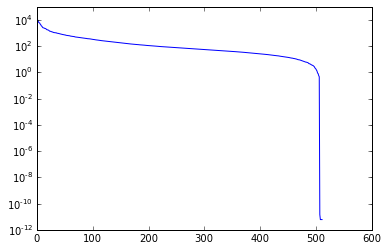

In [23]:
U, s, V = np.linalg.svd(lena)
plt.semilogy(s)

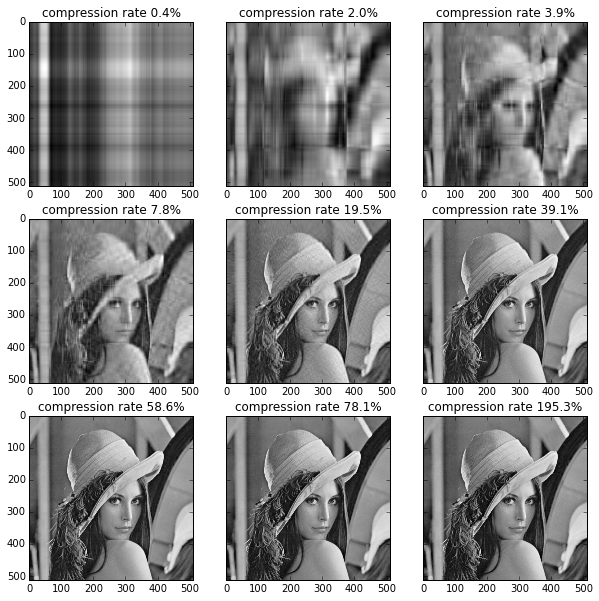

In [32]:
ranks = np.array([[1, 5, 10], [20, 50, 100], [150, 200, 500]])

fig, axes = plt.subplots(3, 3, sharey=True, figsize=(10, 10))
for (i, j), r in np.ndenumerate(ranks):
    U1 = U[:, :r]
    s1 = s[:r]
    V1 = V[:r, :]
    axes[i, j].imshow(U1.dot(np.diag(s1).dot(V1)), cmap = 'gray')
    axes[i, j].set_title('compression rate {0:.1f}%'.format(100. * r / 256))

# Bonus Problem

In [38]:
n = 2
i, j, k = np.meshgrid(np.arange(n), np.arange(n), np.arange(n))
A = 1. / (i + j + k + 1)
print A

[[[ 1.          0.5       ]
  [ 0.5         0.33333333]]

 [[ 0.5         0.33333333]
  [ 0.33333333  0.25      ]]]
